Hi gens! My idea is applying **Coulomb Interaction** which force is propotional to inversed squared distance (1/r^2). Inversed distance (1/r) can be applicable when focusing on potential. Anyway, i've considered inversed squared distance, here.

1. get assigned atoms from train data which are included 'atom_index_0' or 'atom_index_1' of molecule
2. get distances from each atom belonging to the molecule and pickup 'num = 5' nearest regarding to each atom [H, C, N, O, F]. Though in this competition we focus on bondings of H-H, H-C, H-N, properties of bondings are strongly affected O, F. That's why I'd like to consider interaction as I mentioned.
3. mearge distance array according to atom_index_0 and atom_index_1 then dimension of feature of bonding is 50 = num x atoms x 2.
4. feed the feature into model. model can be built for each bonding type, 1JHH, 1JHC, 2JHC etc.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

import pickle

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'
os.listdir(FOLDER)

['mulliken_charges.csv',
 'sample_submission.csv',
 'magnetic_shielding_tensors.csv',
 'train.csv',
 'test.csv',
 'dipole_moments.csv',
 'potential_energy.csv',
 'structures.csv',
 'out',
 'scalar_coupling_contributions.csv',
 'dsgdb9nsd_000001.xyz',
 'structures.zip']

In [3]:
# df_mulliken_charges = pd.read_csv(FOLDER + 'mulliken_charges.csv')
# df_sample =  pd.read_csv(FOLDER + 'sample_submission.csv')
# df_magnetic_shielding_tensors = pd.read_csv(FOLDER + 'magnetic_shielding_tensors.csv')
df_train = pd.read_csv(FOLDER + 'train.csv')
# df_test = pd.read_csv(FOLDER + 'test.csv')
# df_dipole_moments = pd.read_csv(FOLDER + 'dipole_moments.csv')
# df_potential_energy = pd.read_csv(FOLDER + 'potential_energy.csv')
df_structures = pd.read_csv(FOLDER + 'structures.csv')
# df_scalar_coupling_contributions = pd.read_csv(FOLDER + 'scalar_coupling_contributions.csv')

to find target bonding

In [4]:
def assign_atoms_index(df, molecule):
    se_0 = df.query('molecule_name == "{}"'.format(molecule))['atom_index_0']
    se_1 = df.query('molecule_name == "{}"'.format(molecule))['atom_index_1']
    assign_idx = pd.concat([se_0, se_1]).unique()
    assign_idx.sort()
    return assign_idx

In [5]:
def get_dist_matrix(df_structures, molecule):
    df_temp = df_structures.query('molecule_name == "{}"'.format(molecule))
    locs = df_temp[['x','y','z']].values
    num_atoms = len(locs)
    loc_tile = np.tile(locs.T, (num_atoms,1,1))
    dist_mat = ((loc_tile - loc_tile.T)**2).sum(axis=1)
    return dist_mat

In [6]:
def get_pickup_dist_matrix(df, df_structures, molecule, num_pickup=5, atoms=['H', 'C', 'N', 'O', 'F']):
    pickup_dist_matrix = np.zeros([0, len(atoms)*num_pickup])
    assigned_idxs = assign_atoms_index(df, molecule) # [0, 1, 2, 3, 4, 5, 6] -> [1, 2, 3, 4, 5, 6]
    dist_mat = get_dist_matrix(df_structures, molecule)
    for idx in assigned_idxs: # [1, 2, 3, 4, 5, 6] -> [2]

        
        dist_arr = dist_mat[idx] # (7, 7) -> (7, )

        atoms_mole = df_structures.query('molecule_name == "{}"'.format(mol))['atom'].values # ['O', 'C', 'C', 'N', 'H', 'H', 'H']
        atoms_mole_idx = df_structures.query('molecule_name == "{}"'.format(mol))['atom_index'].values # [0, 1, 2, 3, 4, 5, 6]

        mask_atoms_mole_idx = atoms_mole_idx != idx # [ True,  True, False,  True,  True,  True,  True]
        masked_atoms = atoms_mole[mask_atoms_mole_idx] # ['O', 'C', 'N', 'H', 'H', 'H']
        masked_atoms_idx = atoms_mole_idx[mask_atoms_mole_idx]  # [0, 1, 3, 4, 5, 6]
        masked_dist_arr = dist_arr[mask_atoms_mole_idx]  # [ 5.48387003, 2.15181049, 1.33269675, 10.0578779, 4.34733927, 4.34727838]

        sorting_idx = np.argsort(masked_dist_arr) # [2, 1, 5, 4, 0, 3]
        sorted_atoms_idx = masked_atoms_idx[sorting_idx] # [3, 1, 6, 5, 0, 4]
        sorted_atoms = masked_atoms[sorting_idx] # ['N', 'C', 'H', 'H', 'O', 'H']
        sorted_dist_arr = 1/masked_dist_arr[sorting_idx] #[0.75035825,0.46472494,0.23002898,0.23002576,0.18235297,0.09942455]

        target_matrix = np.zeros([len(atoms), num_pickup])
        for a, atom in enumerate(atoms):
            pickup_atom = sorted_atoms == atom # [False, False,  True,  True, False,  True]
            pickup_dist = sorted_dist_arr[pickup_atom] # [0.23002898, 0.23002576, 0.09942455]
            num_atom = len(pickup_dist)
            if num_atom > num_pickup:
                target_matrix[a, :] = pickup_dist[:num_pickup]
            else:
                target_matrix[a, :num_atom] = pickup_dist
        pickup_dist_matrix = np.vstack([pickup_dist_matrix, target_matrix.reshape(-1)])
    return pickup_dist_matrix

In [7]:
# num = 5
# mols = df_train['molecule_name'].unique()
# dist_mat = np.zeros([0, num*5])
# atoms_idx = np.zeros([0], dtype=np.int32)
# molecule_names = np.empty([0])

# start = time.time()

# for mol in mols:
    
#     assigned_idxs = assign_atoms_index(df_train, mol)
#     dist_mat_mole = get_pickup_dist_matrix(df_train, df_structures, mol, num_pickup=num)
#     mol_name_arr = [mol] * len(assigned_idxs) 
    
#     molecule_names = np.hstack([molecule_names, mol_name_arr])
#     atoms_idx = np.hstack([atoms_idx, assigned_idxs])
#     dist_mat = np.vstack([dist_mat, dist_mat_mole])
    
# col_name_list = []
# atoms = ['H', 'C', 'N', 'O', 'F']
# for a in atoms:
#     for n in range(num):
#         col_name_list.append('dist_{}_{}'.format(a, n))
        
# se_mole = pd.Series(molecule_names, name='molecule_name')
# se_atom_idx = pd.Series(atoms_idx, name='atom_index')
# df_dist = pd.DataFrame(dist_mat, columns=col_name_list)
# df_distance = pd.concat([se_mole, se_atom_idx,df_dist], axis=1)

# elapsed_time = time.time() - start
# print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

In [8]:
# df_distance.to_csv(OUTPUT + 'distance.csv', index=False)

In [9]:
# df_dist = pd.read_csv(OUTPUT + 'distance.csv')

In [10]:
def merge_atom(df, df_distance):
    df_merge_0 = pd.merge(df, df_distance, left_on=['molecule_name', 'atom_index_0'], right_on=['molecule_name', 'atom_index'])
    df_merge_0_1 = pd.merge(df_merge_0, df_distance, left_on=['molecule_name', 'atom_index_1'], right_on=['molecule_name', 'atom_index'])
    del df_merge_0_1['atom_index_x'], df_merge_0_1['atom_index_y']
    return df_merge_0_1

In [11]:
# start = time.time()
# df_train_dist = merge_atom(df_train, df_dist)
# elapsed_time = time.time() - start
# print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

In [12]:
# df_train_dist.to_csv(OUTPUT + 'train_dist.csv', index=False)

In [13]:
df_train_dist = pd.read_csv(OUTPUT + 'train_dist.csv')

In [14]:
def type_score(y_val, y_pred):
    return np.log(sum(np.abs(y_val- y_pred)) / len(y_val))

In [15]:
bond_types = df_train_dist['type'].unique()

In [16]:
mols = df_train_dist['molecule_name'].unique()
num = len(mols)
num_train = int(num * 0.8)
pickup = random.sample(range(num), num)
pick_train = pickup[:num_train]
pick_val = pickup[num_train:]

In [17]:
models = []
scores = np.zeros([0])
for i, b in enumerate(bond_types):
    df_bond = df_train_dist.query('type == "{}"'.format(b))
    
    df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    
    df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values
    
    model = lgb.LGBMRegressor()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val).reshape(-1)
    
    y_pred_train = model.predict(X_train).reshape(-1)
    score = type_score(y_val, y_pred)
    scores = np.hstack([scores, score])
    print('type score:', score)
    models.append(model)
print('total score:', scores.mean())

type score: 0.5116065941045849
type score: -0.8466162905082507
type score: -0.48980271534514935
type score: -0.7999319712492969
type score: -0.17628403142187873
type score: 0.3967468296084313
type score: 0.5224934961054509
type score: -0.943919000962148
total score: -0.22821338620853207


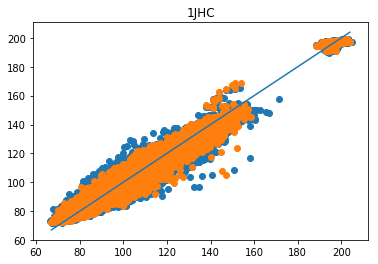

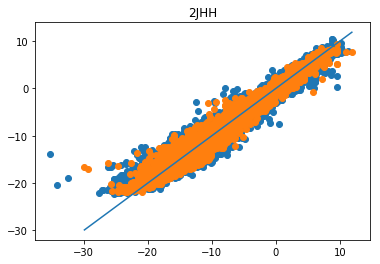

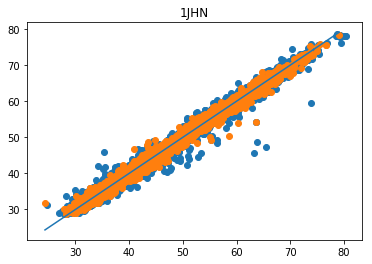

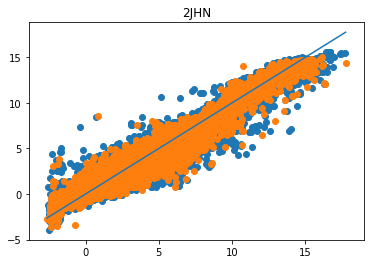

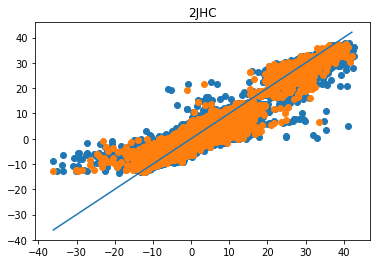

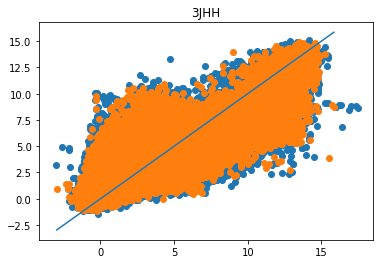

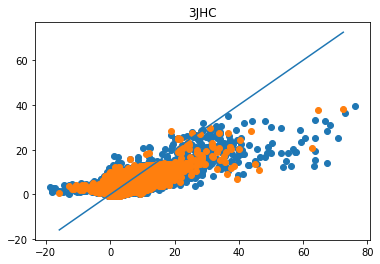

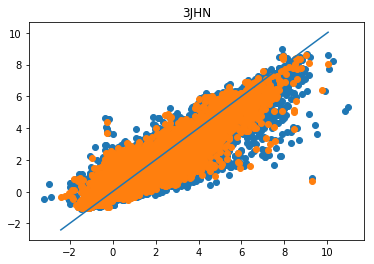

In [19]:
for i, b in enumerate(bond_types):
    df = df_train_dist.query('type == "{}"'.format(b))
    y = df['scalar_coupling_constant'].values
    X = df[df.columns[6:]].values

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    model = models[i]
    
    y_pred = model.predict(X_val)
    y_pred_train = model.predict(X_train)
    plt.scatter(y_train, y_pred_train)
    plt.scatter(y_val, y_pred)
    plt.title('{}'.format(b))
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()])
    plt.show()

In [20]:
with open(OUTPUT + '20190609_champs_models_lgb.pickle', 'wb') as f:
    pickle.dump(models, f)